In [ ]:
from google.colab import drive

drive.mount("/content/gdrive") 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/Bloque 2 IA/Estadistica/Entregable 2"
!ls

/content/gdrive/MyDrive/Bloque 2 IA/Estadistica/Entregable 2
'Entregable 2.ipynb'   Indicadores.xlsx


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Entregable 2

## Lectura de datos

In [ ]:
df = pd.read_excel('Indicadores.xlsx')
df

,Periodo,Valor
0,2022/07,111.274552
1,2022/06,112.797501
2,2022/05,114.442424
3,2022/04,109.529866
4,2022/03,111.940152
...,...,...
350,1993/05,63.612900
351,1993/04,61.865984
352,1993/03,63.943249
353,1993/02,61.022521


Sorteamos los valores segun el periodo, receteamos y dropeamos los index para poder reordenar de forma periodica los datos

In [ ]:
df = df.sort_values(by='Periodo')
df = df.reset_index(drop=True)

##Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable

Podemos ver segun el plot de 'Valor' que nuestra variable es no estacionaria, ya que tiene un crecimiento visible

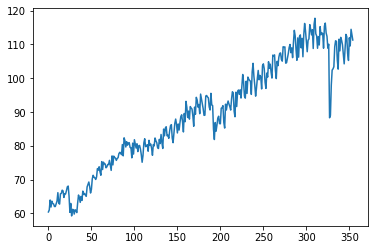

In [ ]:
df['Valor'].plot()

Calculamos la diferencia entre el logaritmo de los valores anuales del crecimiento indice de volumen fisico base, esto con el fin de estacionarizar los datos 

In [ ]:
df['lnair'] = np.log(df['Valor'])  - np.log(df['Valor']).shift(12)
df

,Periodo,Valor,lnair
0,1993/01,60.407691,NaN
1,1993/02,61.022521,NaN
2,1993/03,63.943249,NaN
3,1993/04,61.865984,NaN
4,1993/05,63.612900,NaN
...,...,...,...
350,2022/03,111.940152,0.003661
351,2022/04,109.529866,0.013414
352,2022/05,114.442424,0.021001
353,2022/06,112.797501,0.014522


Dropeamos nans

In [ ]:
df = df.dropna()

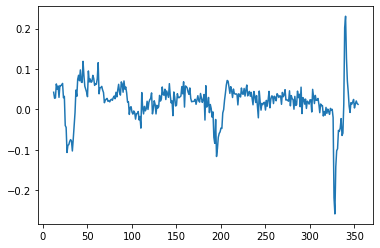

In [ ]:
df['lnair'].plot()

Con este grafico, podemos ver cierta tendencia a estacionaridad, pero para poder comprobar esto, usaremos el Dicky-Fuller test

https://www.statology.org/dickey-fuller-test-python/

In [ ]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df['lnair'])
p_value[1]

0.0032602635688594108

Podemos ver que tenemos un p-value de 0.00320, por lo que posemos usar los valores de D = 1 y d = 0 para calcular el porcentaje de cambio anual segun el mes, debido a que nuestra variable ya es estacionaria y con esto proseguimos a usar un modelo ARIMA-SARIMA

## Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

Realizamos el grafico de autocorrelaciones (ACF) y una autocorrelacion parcial de los datos(PACF) para conocer la aucorrelacion de los datos con sus lags

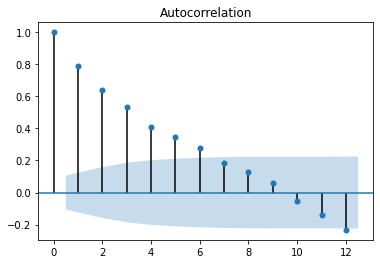

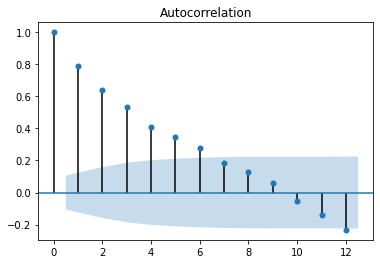

In [ ]:
plot_acf(df['lnair'], lags = 12)

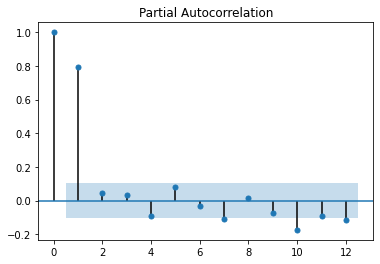

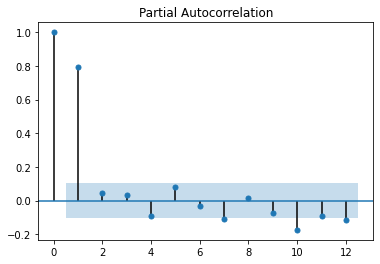

In [ ]:
plot_pacf(df['lnair'], lags = 12)

En el grafico de autocorrelacion, podemos ver que esta va descendiendo, entre mayor el lag, y nos damos cueta que los lags anteriores a 7 se encuentran por encima del 95% de significancia.

Por otro lado, en la autocorrelacion parcial unicamente se ve una autocorrelacion explictiva en el primer lag.

Debido a esto, tomaremos un valor de p = 1 y q = 0


##Estimacion del modelo ARIMA-SARIMA

Variables para el modelo ARIMA-SARIMA

###Modelo 1

In [ ]:
#Arima(1,0,0)
p = 1
q = 0
d = 0

#SARIMA(0,0,1,12)
P = 0
Q = 0
D = 1
num_per = 12

In [ ]:
import statsmodels.api as sm

df['y'] = np.log(df['Valor'])
model1 = sm.tsa.statespace.SARIMAX(df['y'], order = (p, d, q), seasonal_order = (P, D, Q, num_per), trend = 'c',  simple_differencing = True)
aux = model1.fit()
print(aux.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                             DS12.y   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 712.497
Date:                            Mon, 24 Oct 2022   AIC                          -1418.994
Time:                                    16:44:35   BIC                          -1407.588
Sample:                                         0   HQIC                         -1414.445
                                            - 331                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.002      2.545      0.011       0.001       0.007
ar.L1          0.7882      0.022   

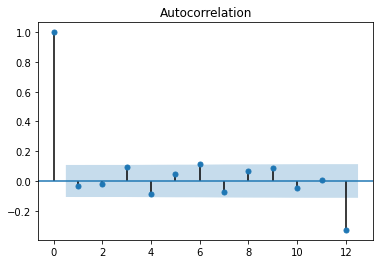

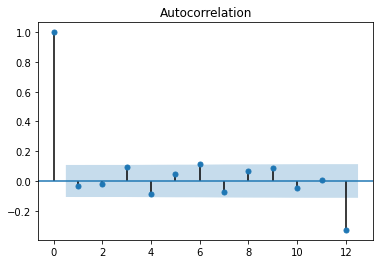

In [ ]:
plot_acf(aux.resid, lags = 12)

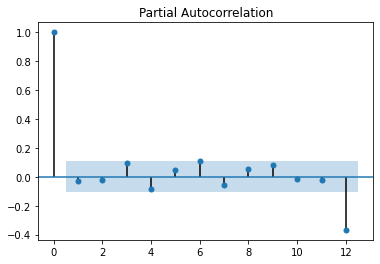

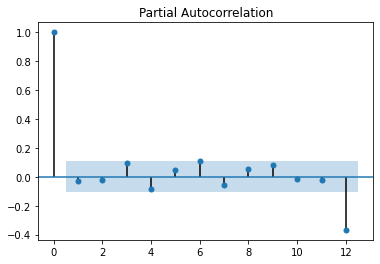

In [ ]:
plot_pacf(aux.resid, lags = 12)

Como podemos ver el las graficas, tenemos ruido en el lag 12, yendo este hacia abajo, por o que cambiaremos el parametro Q de 0 a 1 para tratar de corregir este error

###Modelo 2

In [ ]:
Q = 1

In [ ]:
modelo2 = sm.tsa.statespace.SARIMAX(df['y'], order = (p, d, q), seasonal_order = (P, D, Q, num_per),  trend = 'c',  simple_differencing = True)
aux2 = modelo2.fit()
print(aux2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                               DS12.y   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 774.971
Date:                              Mon, 24 Oct 2022   AIC                          -1541.943
Time:                                      16:44:40   BIC                          -1526.734
Sample:                                           0   HQIC                         -1535.877
                                              - 331                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.000      6.075      0.000       0.002       0.003
ar.L1          0.87

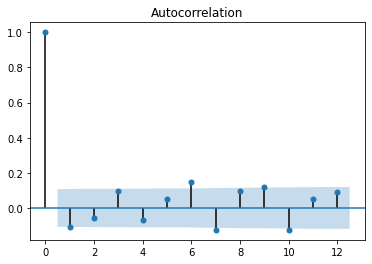

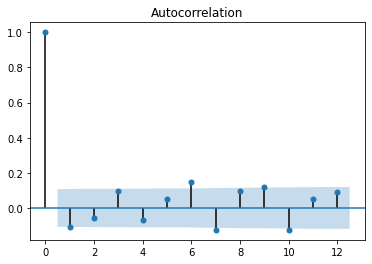

In [ ]:
plot_acf(aux2.resid, lags = 12)

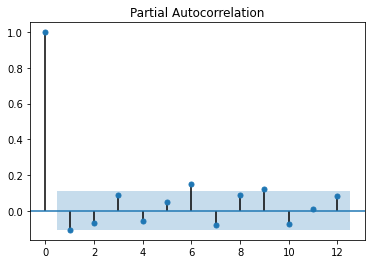

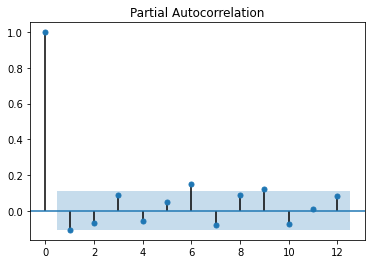

In [ ]:
plot_pacf(aux2.resid, lags = 12)

Como podemos ver en estos graficos, los lags de la variable ya se encientran todas por debajo del 95% o muy cerca, tanto en la cutocorrelacion parcial como en la normal, por lo que ya no generan ruido en nuestro modelo. 

En cuanto al p-value de nuestras variables, todos tienen un valor muy bajo, por lo que las variables pueden ser consideradas como relevantes. 

Gracias a esto, ya podemos generar un modelo, el cual seria:

y_(t) = 0.0024 + 0.8794 * y_(t-1) - 0.8455 * E_(t-12) +- 0.0005(Desviacion estandar)

Con esto, nos damos cuenta que el valor de 'y' anterior, tiene una significancia del 87.94% para la y actual

##Prediccion

In [ ]:
inter = 0.0024
a1 = 0.8794
a2 = -0.8455
E = -0.5 / 0.8455

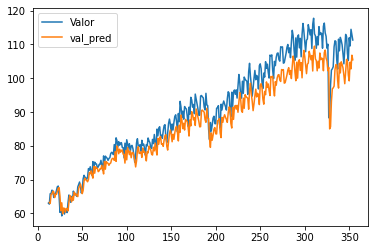

In [ ]:
df[['Valor', 'val_pred']].plot()

###Prediccion del siguiente mes 

Para predecir el siguiente mes, usamos los valores obtenidos en el modelo y el ultimo dato registrado

In [ ]:
y_pred = inter + a1 * df['y'][len(df)] + a2 * E
valor_pred = np.exp(y_pred)

In [ ]:
valor_pred

100.83524036319294